# Data preparation

Initially, each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In our project we considered only the speech videos (vocal channel=01) with both audio and video (modality=01)

We import the libraries and extract the filenames into the Notebook environment.

In [1]:
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
import re
import os
import pandas as pd
import cv2
import random
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score, ConfusionMatrixDisplay
from tqdm import tqdm
from datetime import datetime

# Keras module and tools
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.layers import Input, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Rescaling, MaxPooling2D
from keras.layers import RandomFlip, CenterCrop, RandomZoom, RandomRotation
from keras_cv.layers import RandomCutout
from keras.metrics import sparse_categorical_accuracy, sparse_top_k_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications import ResNet50, Xception
#from keras_cv.layers import RandomCutout
#import keras_tuner

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [3]:
emotions = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
emotional_intensity = {1:'normal', 2:'strong'}

In [4]:
path = "Datasets/RAVDESS/"
filenames = []
feats = []
labels = []
paths = []

for (dirpath, dirnames, fn) in os.walk(path):
    for name in fn:
        filename = name.split('.')[0]
        feat = filename.split('-')[2:]
        label = feat[0]
        filenames.append(filename)
        feats.append(feat)
        labels.append(label)
        paths.append(dirpath + '/' + filename)
        
filenames[:5]

['01-01-01-01-01-01-01',
 '01-01-01-01-01-02-01',
 '01-01-01-01-02-01-01',
 '01-01-01-01-02-02-01',
 '01-01-02-01-01-01-01']

# Data Exploration

We import the filenames into dataframe to determine the emotion, emotional intensity, statement, repetition, actor for every RAVDESS data video.

In [4]:
df = pd.DataFrame(feats, columns = ['emotion', 'emotional intensity', 'statement', 'repetition', 'actor']).astype(int)

df['emotion'] = df['emotion'].map(emotions)
df['emotional intensity'] = df['emotional intensity'].map(emotional_intensity)

df['index'] = filenames
df.set_index('index', inplace=True)

df

,emotion,emotional intensity,statement,repetition,actor
index,,,,,
01-01-01-01-01-01-01,happy,normal,1,1,1
01-01-01-01-01-02-01,happy,normal,1,2,1
01-01-01-01-02-01-01,happy,normal,2,1,1
01-01-01-01-02-02-01,happy,normal,2,2,1
01-01-02-01-01-01-01,sad,normal,1,1,1
...,...,...,...,...,...
01-01-08-01-02-02-24,NaN,normal,2,2,24
01-01-08-02-01-01-24,NaN,strong,1,1,24
01-01-08-02-01-02-24,NaN,strong,1,2,24


# Export frames

- one frame every three (hop) starting from the 21th frame
- proportional resize to obtain height=224 and width=224
- saved as png with and name videoname_iframe

#### 398x224 normal

In [ ]:
def prepare_all_videos(filenames, paths, hop=1):

    for count, video in enumerate(zip(filenames, paths)):
        # Gather all its frames and save them in 'RAVDESS_frames' folder
        save_frames(video[0], video[1], video[1].replace('RAVDESS', 'RAVDESS_frames'), hop) 
        print(f"Processed videos {count+1}/{len(paths)}")
    return


def save_frames(filename, input_path, output_path, hop):
    # Initialize video reader
    cap = cv2.VideoCapture(input_path + '.mp4')
    count = 0
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Loop through all frames
    while True:
        # Capture frame
        ret, frame = cap.read()
        if (count % hop == 0 and count > 20):
            #print(frame.shape)
            if not ret:
                break
            frame = cv2.resize(frame, (398, 224))
            cv2.imwrite(output_path + '/' + f'{filename}_{count}' + '.png', frame)
        count += 1
    cap.release()
    return

In [ ]:
prepare_all_videos(filenames, paths, hop=3)

Processed videos 1/1440
Processed videos 2/1440
Processed videos 3/1440
Processed videos 4/1440
Processed videos 5/1440
Processed videos 6/1440
Processed videos 7/1440
Processed videos 8/1440
Processed videos 9/1440
Processed videos 10/1440
Processed videos 11/1440
Processed videos 12/1440
Processed videos 13/1440
Processed videos 14/1440
Processed videos 15/1440
Processed videos 16/1440
Processed videos 17/1440
Processed videos 18/1440
Processed videos 19/1440
Processed videos 20/1440
Processed videos 21/1440
Processed videos 22/1440
Processed videos 23/1440
Processed videos 24/1440
Processed videos 25/1440
Processed videos 26/1440
Processed videos 27/1440
Processed videos 28/1440
Processed videos 29/1440
Processed videos 30/1440
Processed videos 31/1440
Processed videos 32/1440
Processed videos 33/1440
Processed videos 34/1440
Processed videos 35/1440
Processed videos 36/1440
Processed videos 37/1440
Processed videos 38/1440
Processed videos 39/1440
Processed videos 40/1440
Processed

#### 224x224 only faces 

In [5]:
def prepare_all_videos(filenames, paths, hop=1):
    
    for count, video in enumerate(zip(filenames, paths)):
        # Gather all its frames and save them in 'RAVDESS_frames_face' folder
        save_frames(video[0], video[1], video[1].replace('RAVDESS', 'RAVDESS_frames_face'), hop)
        print(f"Processed videos {count+1}/{len(paths)}")
    return


def save_frames(filename, input_path, output_path, hop):
    # Initialize video reader
    cap = cv2.VideoCapture(input_path + '.mp4')
    haar_cascade = cv2.CascadeClassifier('./Other/haarcascade_frontalface_default.xml')
    count = 0
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Loop through all frames
    while True:
        # Capture frame
        ret, frame = cap.read()
        if (count % hop == 0 and count > 20):
            if not ret:
                break
            faces = haar_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=9)
                    
            if len(faces) == 0:
                faces = haar_cascade.detectMultiScale(frame, scaleFactor=1.01, minNeighbors=9)
                if len(faces) == 0:
                   print(f"Still no faces {len(faces)} {filename}")
            if len(faces) > 1:
                ex = []
                for elem in faces:
                    for (x, y, w, h) in [elem]:
                        ex.append(frame[y:y + h, x:x + w])

            for (x, y, w, h) in faces:
                face = frame[y:y + h, x:x + w]

            face = cv2.resize(face, (234, 234))
            face = face[5:-5, 5:-5]
            cv2.imwrite(output_path + '/' + f'{filename}_{count}' + '.png', face)
        count += 1
    cap.release()
    return

In [8]:
prepare_all_videos(filenames, paths, hop=3)

Processed videos 1/1440
Processed videos 2/1440
Processed videos 3/1440
Processed videos 4/1440
Processed videos 5/1440
Processed videos 6/1440
Processed videos 7/1440
Processed videos 8/1440
Processed videos 9/1440
Processed videos 10/1440
Processed videos 11/1440
Processed videos 12/1440
Processed videos 13/1440
Processed videos 14/1440
Processed videos 15/1440
Processed videos 16/1440
Processed videos 17/1440
Processed videos 18/1440
Processed videos 19/1440
Processed videos 20/1440
Processed videos 21/1440
Processed videos 22/1440
Processed videos 23/1440
Processed videos 24/1440
Processed videos 25/1440
Processed videos 26/1440
Processed videos 27/1440
Processed videos 28/1440
Processed videos 29/1440
Processed videos 30/1440
Processed videos 31/1440
Processed videos 32/1440
Processed videos 33/1440
Processed videos 34/1440
Processed videos 35/1440
Processed videos 36/1440
Processed videos 37/1440
Processed videos 38/1440
Processed videos 39/1440
Processed videos 40/1440
Processed

### Parameters


In [2]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}   # to match the correct labels
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'} 

path_frames = "Datasets/RAVDESS_frames/"
path_frames_face = "Datasets/RAVDESS_frames_face/"

val_actors = ['19', '20']
test_actors = ['21', '22', '23', '24']

height_orig = 224
width_orig = 224
width_orig_full = 398
height_targ = 112
width_targ = 112

batch_size = 64
num_classes = len(emotions)

## Models Full Frame 224x224 color

### Data Preprocessing 


We split the frames into train, validation, test. Then we correspond every train and validation frame to it's emotion label, creating two lists 'filenames_train', 'filenames_val' with the path and the label of their frames.

In [5]:
train_frames_fullColor = []                                                     # train
val_frames_fullColor= []                                                        # validation

for (root, dirs, files) in os.walk(path_frames):
    if files != []:
        label_temp = int(files[0].split('-')[2]) - 1
        if label_temp != 0:                                                     # exclude 'neutral' label
            if any(actor in root for actor in (test_actors+val_actors))==False: # select only train actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)                # emotion transposition
                train_frames_fullColor.append(list(zip(path, label)))

            if any(actor in root for actor in val_actors):                      # select only validation actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)
                val_frames_fullColor.append(list(zip(path, label)))

### Data Loaders

We sampling the data to be balanced and loading the full frames in shape (224,224) to data loaders.

In [7]:
# function that randomly sampling the same amount of frames among the files to balance the data
def sampling(list_frames, num_frames_desired):
    frames_sampled = []
    for frame in list_frames:
        sampled_list = random.sample(frame, num_frames_desired)
        frames_sampled += sampled_list
    return (frames_sampled)

# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.
def parse_image(filename):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
  return image

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    names = [frame[0] for frame in filenames_sampled]              # we seperatie the name and label of balanced frames
    labels = [frame[1] for frame in filenames_sampled]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))

    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [8]:
train_ds_fullColor, step_per_epoch_train = load_dataset(train_frames_fullColor, batch_size)

frames per video: 23
frames number: 23184 
batch size: 64 
batch number: 362


In [9]:
val_ds_fullColor, step_per_epoch_val = load_dataset(val_frames_fullColor, batch_size)


frames per video: 24
frames number: 2688 
batch size: 64 
batch number: 42


We augemntate the data by randomly fliping, cutting and zooming the frames.

### Data Augemntation

In [11]:
data_augmentation_fullColor = tf.keras.Sequential([
    RandomFlip("horizontal"),
    CenterCrop(224, 224),
    RandomZoom(height_factor=(-0.2, 0.2))
    ])

### Visual data

We visualize some examples after the above processing.

(224, 398, 3)


(-0.5, 397.5, 223.5, -0.5)

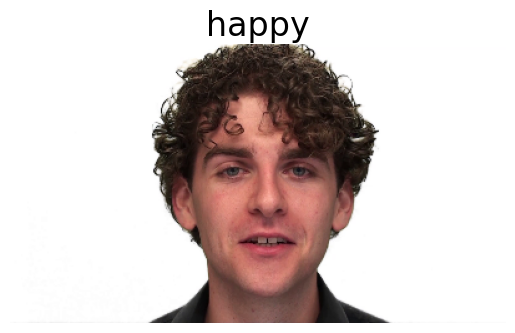

In [12]:
examples = train_ds_fullColor.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)

o = elem[0]
plt.imshow(o)
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')

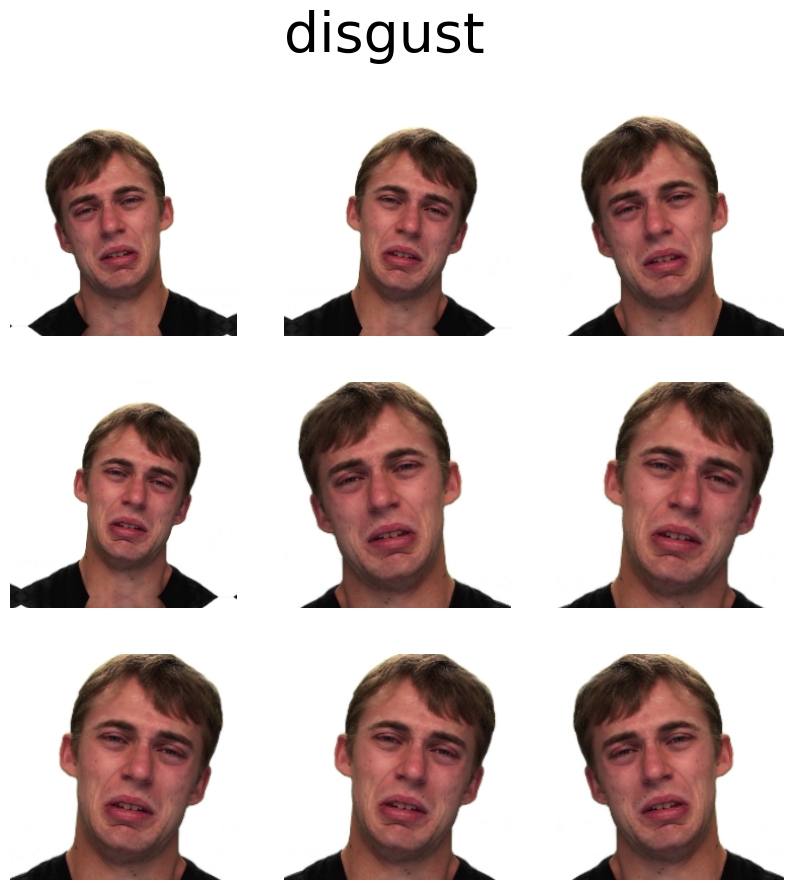

In [39]:
for images, labels in train_ds_fullColor.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_fullColor(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")

We are ready to build some net architectures and train them in order to pick the best.

### Train Models


#### Transfer Learning at RAVDESS FRAMES 

ResNet50

In [103]:
# ResNet50 model
resnet50 = ResNet50(include_top=False,
                    weights='imagenet',
                    pooling='avg',
                    input_shape=(height_orig, width_orig, 3))
for layer in resnet50.layers:
    layer.trainable = False

In [104]:
# build the entire model
input = Input(shape=(height_orig, width_orig_full, 3))
x = input
x = data_augmentation_fullColor(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = resnet50(x, training=False)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)
model0 = Model(input, output)
model0.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 398, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, None)    0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_46 (Dense)            (None, 512)               104

In [105]:
model0.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_0 = model0.fit(train_ds_fullColor,
                    epochs=10,
                    validation_data=val_ds_fullColor,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10


362/362 [==============================] - 1158s 3s/step - loss: 1.9706 - accuracy: 0.1597 - val_loss: 1.9475 - val_accuracy: 0.1908
Epoch 2/10
362/362 [==============================] - 1148s 3s/step - loss: 1.9253 - accuracy: 0.1913 - val_loss: 1.9280 - val_accuracy: 0.1551
Epoch 3/10
362/362 [==============================] - 1146s 3s/step - loss: 1.8974 - accuracy: 0.2170 - val_loss: 1.9352 - val_accuracy: 0.1633
Epoch 4/10
362/362 [==============================] - 1157s 3s/step - loss: 1.8719 - accuracy: 0.2326 - val_loss: 1.9975 - val_accuracy: 0.2199
Epoch 5/10
362/362 [==============================] - 1150s 3s/step - loss: 1.8477 - accuracy: 0.2404 - val_loss: 2.0101 - val_accuracy: 0.1868
Epoch 6/10
362/362 [==============================] - 1147s 3s/step - loss: 1.8157 - accuracy: 0.2607 - val_loss: 1.9783 - val_accuracy: 0.1812
Epoch 7/10
362/362 [==============================] - 1156s 3s/step - loss: 1.7847 - accuracy: 0.2822 - val_loss: 2.0913 - val_accuracy: 0.1786
Epo

Xception

In [12]:
xception = Xception(weights='imagenet',
                  pooling='avg',
                  include_top=False,
                  input_shape=(height_orig, width_orig, 3))
for layer in xception.layers:
    layer.trainable = False

In [13]:
input = Input(shape=(height_orig, width_orig_full, 3))
x = input
x = data_augmentation_fullColor(x)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = xception(x, training=False)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x) 
model1 = Model(input, output)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 398, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                             

In [ ]:
model1.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_1 = model1.fit(train_ds_fullColor,
                    epochs=10,
                    validation_data=val_ds_fullColor,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10


362/362 [==============================] - 2665s 7s/step - loss: 2.2939 - accuracy: 0.1519 - val_loss: 1.9276 - val_accuracy: 0.1845
Epoch 2/10
362/362 [==============================] - 2671s 7s/step - loss: 1.9496 - accuracy: 0.1500 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 3/10
362/362 [==============================] - 2624s 7s/step - loss: 1.9460 - accuracy: 0.1401 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 4/10
362/362 [==============================] - 2594s 7s/step - loss: 1.9460 - accuracy: 0.1368 - val_loss: 1.9459 - val_accuracy: 0.1429
Epoch 5/10
 72/362 [====>.........................] - ETA: 31:12 - loss: 1.9460 - accuracy: 0.1404

: 

: 

#### CNN at RAVDESS FRAMES 


In [ ]:
input = Input(shape=(width_orig, height_orig, 3))
x = input
x = data_augmentation_fullColor(x)

x = Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Dropout(0.4)(x)

x = Dense(num_classes, activation='softmax')(x)

output = x

model2 = Model(input, output)
model2.summary()

In [ ]:
model2.compile(
        optimizer = Adam(learning_rate=0.001),
        loss = "sparse_categorical_crossentropy",
        metrics = ["sparse_categorical_accuracy"],
    )

In [ ]:
history_2 = model2.fit(train_ds_fullColor,
                    epochs=30,
                    validation_data=val_ds_fullColor,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

## Models Full Frame 112x112 Black-White
### Data Preprocessing 


In [4]:
train_frames_fullBW = []                                                        # train
val_frames_fullBW= []                                                           # validation

for (root, dirs, files) in os.walk(path_frames):
    if files != []:
        label_temp = int(files[0].split('-')[2]) - 1
        if label_temp != 0:                                                     # exclude 'neutral' label
            if any(actor in root for actor in (test_actors+val_actors))==False: # select only train actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)                # emotion transposition
                train_frames_fullBW.append(list(zip(path, label)))

            if any(actor in root for actor in val_actors):                      # select only validation actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)
                val_frames_fullBW.append(list(zip(path, label)))

### Data loaders

In [5]:
# function that randomly sampling the same amount of frames among the files to balance the data
def sampling(list_frames, num_frames_desired):
    frames_sampled = []
    for frame in list_frames:
        sampled_list = random.sample(frame, num_frames_desired)
        frames_sampled += sampled_list
    return (frames_sampled)

# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    names = [frame[0] for frame in filenames_sampled]              # we seperatie the name and label of balanced frames
    labels = [frame[1] for frame in filenames_sampled]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))

    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [6]:
train_ds_fullBW, step_per_epoch_train = load_dataset(train_frames_fullBW, batch_size)


frames per video: 23
shape frames: (112, 112, 1)
frames number: 23184 
batch size: 64 
batch number: 362


In [7]:
val_ds_fullBW, step_per_epoch_val = load_dataset(val_frames_fullBW, batch_size)


frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 64 
batch number: 42


### Data Augmentation


In [8]:
data_augmentation_fullBW = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None),
    RandomZoom(height_factor=(-0.2, 0.2))
    ])

### Visual data

We visualize some examples after the above processing.

(112, 112, 1)


(-0.5, 111.5, 111.5, -0.5)

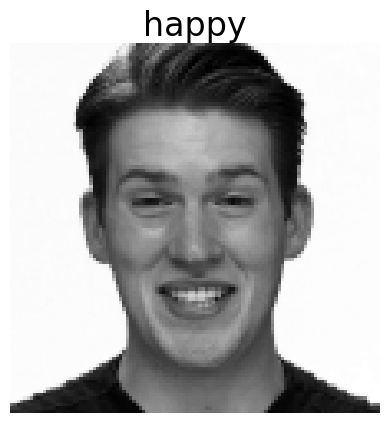

In [9]:
examples = train_ds_fullBW.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')

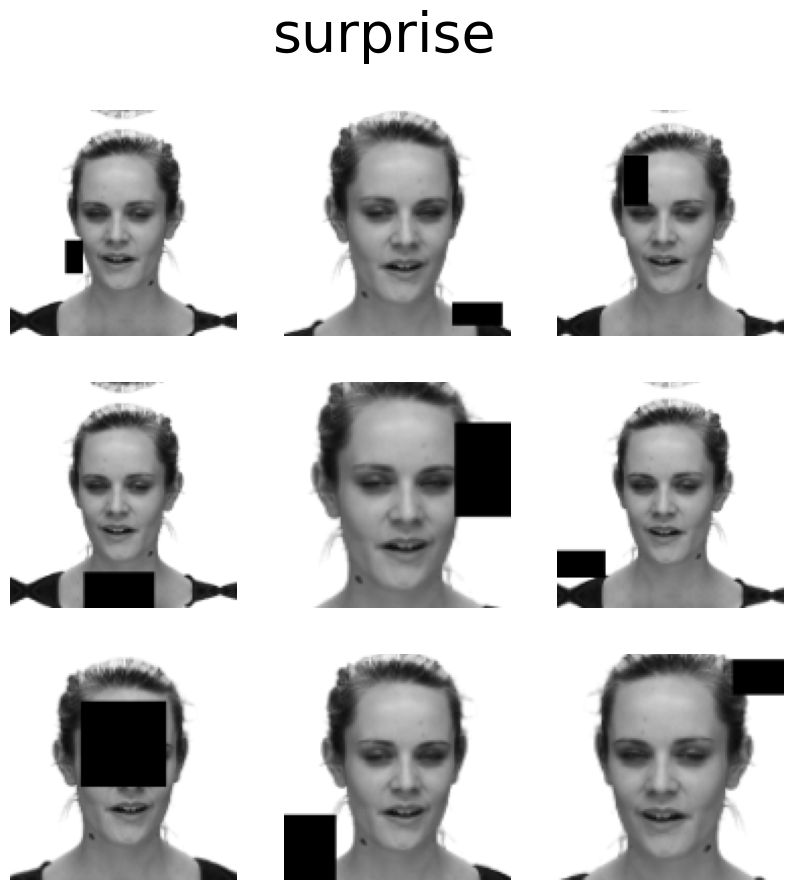

In [10]:
for images, labels in train_ds_fullBW.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_fullBW(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")

### Train Models

CNN

In [11]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation_fullBW(x)

x = Conv2D(32, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(128, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Dropout(0.4)(x)

x = Dense(num_classes, activation='softmax')(x)

output = x

model3 = Model(input, output)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                           

In [12]:
model3.compile(
        optimizer = Adam(learning_rate=0.001),
        loss = "sparse_categorical_crossentropy",
        metrics = ["sparse_categorical_accuracy"],
    )

In [ ]:
history_3 = model3.fit(train_ds_fullBW,
                    epochs=30,
                    validation_data=val_ds_fullBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/30
  4/362 [..............................] - ETA: 6:33 - loss: 2.6594 - sparse_categorical_accuracy: 0.1484

: 

: 

ResNet50

In [16]:
train_ds_fullBW = train_ds_fullBW.map(lambda x, y: (tf.repeat(x,3,-1),y))
val_ds_fullBW = val_ds_fullBW.map(lambda x, y: (tf.repeat(x,3,-1),y))

In [17]:
for image, label in train_ds_fullBW:
    print(image.shape)
    break

(64, 112, 112, 3)


In [18]:
for image, label in val_ds_fullBW:
    print(image.shape)
    break

(64, 112, 112, 3)


In [28]:
pretrained_model = ResNet50(
            include_top=False,
             weights = 'imagenet',
             pooling= 'avg',
             input_shape=(height_targ, width_targ, 3),
            )
                
pretrained_model.trainable = False
                
input = Input(shape=(height_targ, width_targ, 3))
x = input
x = data_augmentation_fullBW(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = pretrained_model(x, training=False)  #'training=False' important for fine-tuning
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)            
output = x

model4 = Model(input, output)
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 112, 112, 3)       0         
                                                                 
 tf.__operators__.getitem_2   (None, 112, 112, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 112, 112, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0   

In [36]:
model4.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_4 = model4.fit(train_ds_fullBW,
                    epochs=20,
                    validation_data=val_ds_fullBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/20


362/362 [==============================] - 439s 1s/step - loss: 1.8246 - sparse_categorical_accuracy: 0.2676 - val_loss: 1.9749 - val_sparse_categorical_accuracy: 0.1503
Epoch 2/20
362/362 [==============================] - 404s 1s/step - loss: 1.8165 - sparse_categorical_accuracy: 0.2778 - val_loss: 1.9775 - val_sparse_categorical_accuracy: 0.1923
Epoch 3/20
362/362 [==============================] - 433s 1s/step - loss: 1.8160 - sparse_categorical_accuracy: 0.2745 - val_loss: 1.9966 - val_sparse_categorical_accuracy: 0.1607
Epoch 4/20
362/362 [==============================] - 465s 1s/step - loss: 1.8111 - sparse_categorical_accuracy: 0.2794 - val_loss: 1.9453 - val_sparse_categorical_accuracy: 0.1815
Epoch 5/20
362/362 [==============================] - 493s 1s/step - loss: 1.8047 - sparse_categorical_accuracy: 0.2856 - val_loss: 1.9367 - val_sparse_categorical_accuracy: 0.1771
Epoch 6/20
362/362 [==============================] - 492s 1s/step - loss: 1.8004 - sparse_categorical_acc

## Models Face Only 112x112 Black-White
### Data Preprocessing 


In [3]:
train_frames_faceBW = []                                                         # train
val_frames_faceBW= []                                                            # validation

for (root, dirs, files) in os.walk(path_frames_face):
    if files != []:
        label_temp = int(files[0].split('-')[2]) - 1
        if label_temp != 0:                                                     # exclude 'neutral' label
            if any(actor in root for actor in (test_actors+val_actors))==False: # select only train actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)                # emotion transposition
                train_frames_faceBW.append(list(zip(path, label)))

            if any(actor in root for actor in val_actors):                      # select only validation actors
                path = [os.path.join(root, frame) for frame in files]
                label = [emotions_tras[label_temp]] * len(files)
                val_frames_faceBW.append(list(zip(path, label)))

### Data Loaders

We sampling the data to be balanced and loading the face only frames in shape (224,224) to data loaders.

In [4]:
# function that randomly sampling the same amount of frames among the files to balance the data
def sampling(list_frames, num_frames_desired):
    frames_sampled = []
    for frame in list_frames:
        sampled_list = random.sample(frame, num_frames_desired)
        frames_sampled += sampled_list
    return (frames_sampled)

# Reads an image from a file, decodes it into a dense tensor, and resizes it to a fixed shape.
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def load_dataset(filenames, batch_size):
    frames_per_vid = min([len(elem) for elem in filenames])     # number of frames per clip in order to have balanced classes
    print("frames per video:", frames_per_vid) 

    filenames_sampled = sampling(filenames, frames_per_vid)
    random.shuffle(filenames_sampled)

    names = [frame[0] for frame in filenames_sampled]              # we seperatie the name and label of balanced frames
    labels = [frame[1] for frame in filenames_sampled]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))

    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [5]:
train_ds_faceBW, step_per_epoch_train = load_dataset(train_frames_faceBW, batch_size)

frames per video: 23
shape frames: (112, 112, 1)
frames number: 23184 
batch size: 64 
batch number: 362


In [6]:
val_ds_faceBW, step_per_epoch_val = load_dataset(val_frames_faceBW, batch_size)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 64 
batch number: 42


### Data Augmentation

In [7]:
data_augmentation_faceBW = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomCutout(0.4, 0.4, fill_mode="constant", fill_value=0.0, seed=None)
    ])

### Visual data

We visualize some examples after the above processing.

(112, 112, 1)


(-0.5, 111.5, 111.5, -0.5)

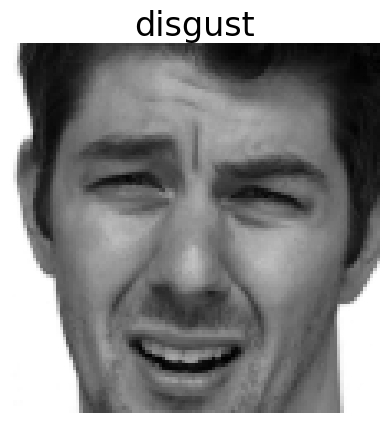

In [8]:
examples = train_ds_faceBW.unbatch().take(1)

for elem in examples:
    print(elem[0].shape)
plt.imshow(elem[0], cmap='gray')
plt.title(emotions[int(elem[1])], fontdict={'fontsize': 24})
plt.axis('off')

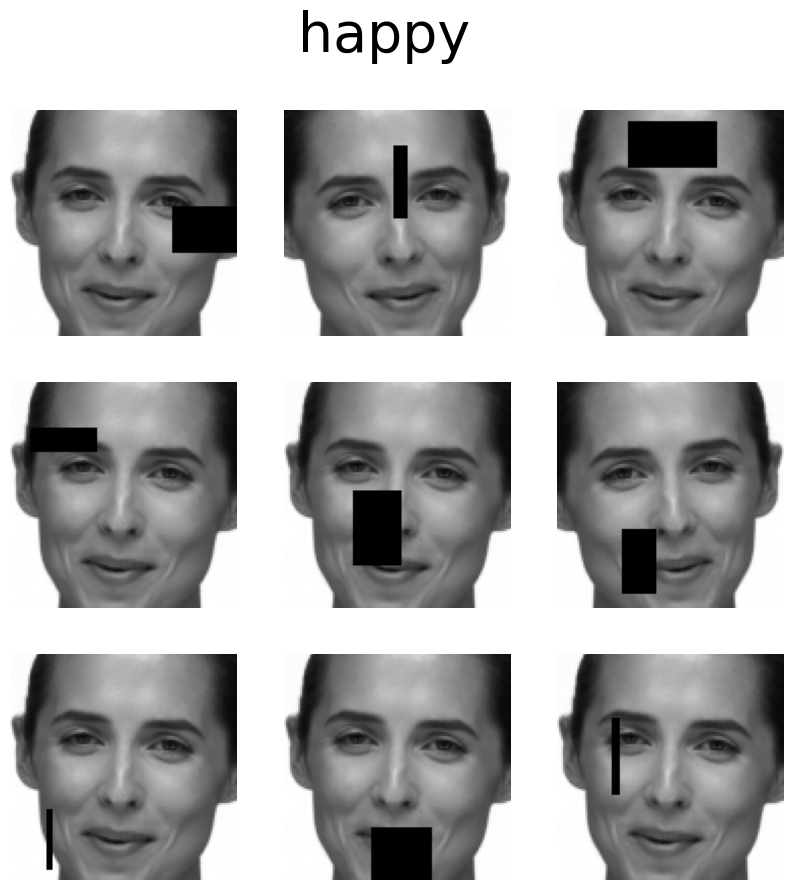

In [9]:
for images, labels in train_ds_faceBW.take(1):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
    fig.suptitle(emotions[int(labels[0])], fontsize=40)
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation_faceBW(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0], cmap='gray')
        plt.axis("off")

### Train Models

CNN

In [10]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
x = data_augmentation_faceBW(x)

x = Conv2D(32, (5,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (5,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)

x = Conv2D(128, (5,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)

x = Conv2D(256, (5,3), padding='same', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2,2))(x)

x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(256, kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Dropout(0.3)(x)

x = Dense(num_classes, activation='softmax')(x)

output = x

model5 = Model(input, output)
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      512       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                           

In [11]:
model5.compile(
        optimizer = Adam(learning_rate=0.001),
        loss = "sparse_categorical_crossentropy",
        metrics = ["sparse_categorical_accuracy"],
    )

In [12]:
history_5 = model5.fit(train_ds_faceBW,
                    epochs=10,
                    validation_data=val_ds_faceBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10


362/362 [==============================] - 440s 1s/step - loss: 1.3177 - sparse_categorical_accuracy: 0.5396 - val_loss: 2.2162 - val_sparse_categorical_accuracy: 0.3579
Epoch 2/10
362/362 [==============================] - 433s 1s/step - loss: 0.6936 - sparse_categorical_accuracy: 0.7517 - val_loss: 2.6209 - val_sparse_categorical_accuracy: 0.4062
Epoch 3/10
362/362 [==============================] - 420s 1s/step - loss: 0.4918 - sparse_categorical_accuracy: 0.8270 - val_loss: 2.1383 - val_sparse_categorical_accuracy: 0.4554
Epoch 4/10
362/362 [==============================] - 423s 1s/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8631 - val_loss: 1.7389 - val_sparse_categorical_accuracy: 0.5205
Epoch 5/10
362/362 [==============================] - 406s 1s/step - loss: 0.3408 - sparse_categorical_accuracy: 0.8804 - val_loss: 1.7444 - val_sparse_categorical_accuracy: 0.5614
Epoch 6/10
362/362 [==============================] - 394s 1s/step - loss: 0.2944 - sparse_categorical_acc

In [14]:
model5.save('Models/Video_stream/model5.h5')

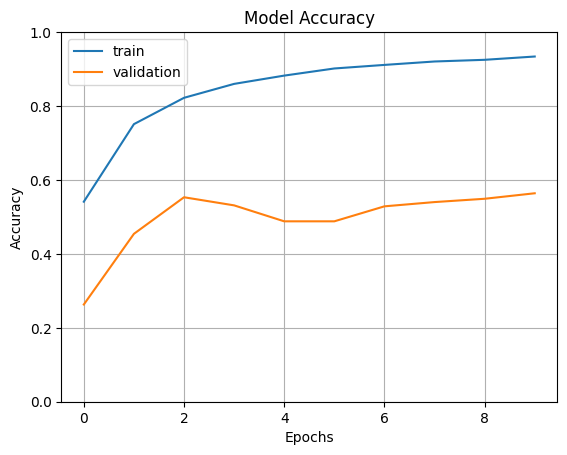

In [34]:
fig1 = plt.gcf()
plt.plot(history_5.history['sparse_categorical_accuracy'])
plt.plot(history_5.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model5_accuracy.png')
plt.show()

In [36]:
y_val = []
y_pred = []
i = 1
for image, target in val_ds_faceBW:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(model5(image, training=False).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       384
           1       0.72      0.70      0.71       384
           2       0.71      0.26      0.38       384
           3       0.50      0.77      0.60       384
           4       0.29      0.26      0.28       384
           5       0.57      0.77      0.66       384
           6       0.57      0.33      0.42       384

    accuracy                           0.56      2688
   macro avg       0.57      0.56      0.54      2688
weighted avg       0.57      0.56      0.54      2688



ResNet50

In [13]:
train_ds_faceBW = train_ds_faceBW.map(lambda x, y: (tf.repeat(x,3,-1),y))
val_ds_faceBW = val_ds_faceBW.map(lambda x, y: (tf.repeat(x,3,-1),y))

In [17]:
for image, label in train_ds_faceBW:
    print(image.shape)
    break

(64, 112, 112, 3)


In [18]:
for image, label in val_ds_faceBW:
    print(image.shape)
    break

(64, 112, 112, 3)


In [15]:
pretrained_model = ResNet50(
            include_top=False,
             weights = 'imagenet',
             pooling= 'avg',
             input_shape=(height_targ, width_targ, 3),
            )
                
pretrained_model.trainable = False
                
input = Input(shape=(height_targ, width_targ, 3))
x = input
x = data_augmentation_faceBW(x)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = pretrained_model(x, training=False)  #'training=False' important for fine-tuning
x = Dropout(0.2)(x)
x = Dense(num_classes, activation='softmax')(x)            
output = x

model6 = Model(input, output)
model6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 112, 112, None)    0         
                                                                 
 tf.__operators__.getitem (S  (None, 112, 112, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 112, 112, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                           

In [16]:
model6.compile(optimizer=Adam(learning_rate=0.001),loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_6 = model6.fit(train_ds_faceBW,
                    epochs=10,
                    validation_data=val_ds_faceBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10
362/362 [==============================] - 321s 874ms/step - loss: 1.9030 - sparse_categorical_accuracy: 0.2148 - val_loss: 1.9138 - val_sparse_categorical_accuracy: 0.2024
Epoch 2/10
362/362 [==============================] - 321s 888ms/step - loss: 1.8088 - sparse_categorical_accuracy: 0.2771 - val_loss: 1.8370 - val_sparse_categorical_accuracy: 0.2292
Epoch 3/10
362/362 [==============================] - 323s 894ms/step - loss: 1.7658 - sparse_categorical_accuracy: 0.2990 - val_loss: 1.8127 - val_sparse_categorical_accuracy: 0.2809
Epoch 4/10
362/362 [==============================] - 327s 903ms/step - loss: 1.7347 - sparse_categorical_accuracy: 0.3234 - val_loss: 1.7985 - val_sparse_categorical_accuracy: 0.2775
Epoch 5/10
362/362 [==============================] - 323s 893ms/step - loss: 1.7115 - sparse_categorical_accuracy: 0.3335 - val_loss: 1.7966 - val_sparse_categorical_accuracy: 0.3069
Epoch 6/10
362/362 [==============================] - 324s 895ms/step - loss: 1.

In [17]:
pretrained_model.trainable = True
model6.compile(optimizer=Adam(learning_rate=1e-5),loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
history_6 = model6.fit(train_ds_faceBW,
                    epochs=10,
                    validation_data=val_ds_faceBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10


362/362 [==============================] - 1329s 4s/step - loss: 1.6863 - sparse_categorical_accuracy: 0.3200 - val_loss: 1.6326 - val_sparse_categorical_accuracy: 0.3690
Epoch 2/10
362/362 [==============================] - 1325s 4s/step - loss: 1.3074 - sparse_categorical_accuracy: 0.5002 - val_loss: 1.9784 - val_sparse_categorical_accuracy: 0.3259
Epoch 3/10
362/362 [==============================] - 1318s 4s/step - loss: 1.1045 - sparse_categorical_accuracy: 0.5872 - val_loss: 1.7780 - val_sparse_categorical_accuracy: 0.4397
Epoch 4/10
362/362 [==============================] - 1291s 4s/step - loss: 0.9466 - sparse_categorical_accuracy: 0.6479 - val_loss: 1.7873 - val_sparse_categorical_accuracy: 0.4531
Epoch 5/10
362/362 [==============================] - 1291s 4s/step - loss: 0.8276 - sparse_categorical_accuracy: 0.6976 - val_loss: 2.0184 - val_sparse_categorical_accuracy: 0.4345
Epoch 6/10
362/362 [==============================] - 1290s 4s/step - loss: 0.7089 - sparse_categoric

In [18]:
model6.save('Models/Video_stream/model6.h5')

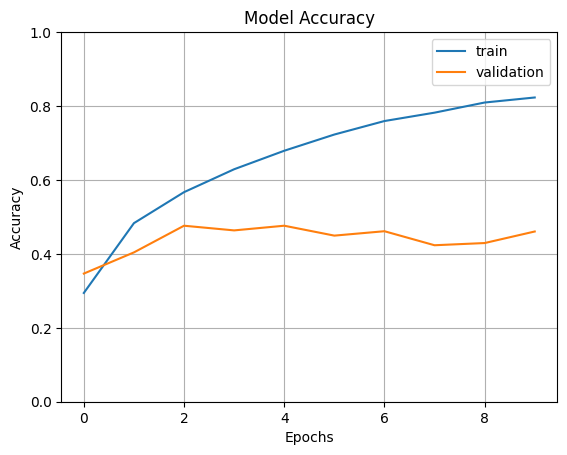

In [33]:
fig1 = plt.gcf()
plt.plot(history_6.history['sparse_categorical_accuracy'])
plt.plot(history_6.history['val_sparse_categorical_accuracy'])
plt.axis(ymin=0, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
# plt.savefig('Plots/model5_accuracy.png')
plt.show()

In [35]:
y_val = []
y_pred = []
i = 1
for image, target in val_ds_faceBW:
  if i > step_per_epoch_val:
    break
  y_val.extend(target.numpy())
  y_pred.extend(model6(image, training=True).numpy().argmax(axis=1))
  i+=1

print(classification_report(y_val, y_pred))

InvalidArgumentError: Exception encountered when calling layer 'tf.nn.bias_add' (type TFOpLambda).

{{function_node __wrapped__BiasAdd_device_/job:localhost/replica:0/task:0/device:CPU:0}} Must provide as many biases as the last dimension of the input tensor: [3] vs. [64,112,112,1] [Op:BiasAdd]

Call arguments received by layer 'tf.nn.bias_add' (type TFOpLambda):
  • value=tf.Tensor(shape=(64, 112, 112, 1), dtype=float32)
  • bias=tf.Tensor(shape=(3,), dtype=float32)
  • data_format='NHWC'
  • name=None

In [41]:
input = Input(shape=(width_targ, height_targ, 1))
x = input
data_augmentation_faceBW(x)

x = Conv2D(filters=32, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_0')(x)
x = BatchNormalization(name='batchnorm_0')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_0')(x)

x = Conv2D(filters=64, kernel_size=(5,5), padding='same', kernel_initializer='he_normal', name='conv2d_1')(x)
x = BatchNormalization(name='batchnorm_1')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(x)

x = Dropout(0.5, name='dropout_1')(x)

x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_2')(x)
x = BatchNormalization(name='batchnorm_2')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(x)

x = Dropout(0.5, name='dropout_2')(x)

x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_3')(x)
x = BatchNormalization(name='batchnorm_3')(x)
x = Activation('elu')(x)
x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(x)

x = Dropout(0.5, name='dropout_3')(x)

# x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal', name='conv2d_4')(x)
# x = BatchNormalization(name='batchnorm_x')(x)
# x = Activation('elu')(x)
# x = MaxPooling2D(pool_size=(2,2), name='maxpool2d_4')(x)

# x = Dropout(0.5, name='dropout_4')(x)

x = Flatten(name='flatten')(x)
x = Dense(128, kernel_initializer='he_normal', name='dense_1')(x)
x = BatchNormalization(name='batchnorm_4')(x)
x = Activation('elu')(x)

x = Dropout(0.6, name='dropout_4')(x)

x = Dense(num_classes, activation='softmax', name='out_layer')(x)

output = x

model7 = Model(inputs=input, outputs=output)
model7.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 conv2d_0 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_0 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation_10 (Activation)  (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        51264     
                                                           

In [42]:
model7.compile(
        optimizer = Adam(learning_rate=0.001),
        # optimizer=keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum)
        loss = sparse_categorical_crossentropy,
        metrics = [sparse_categorical_accuracy],
    )

In [43]:
history_7 = model7.fit(train_ds_faceBW,
                    epochs=10,
                    validation_data=val_ds_faceBW,
                    batch_size=batch_size,
                    steps_per_epoch=step_per_epoch_train,
                    validation_steps=step_per_epoch_val,
                    verbose=1)

Epoch 1/10


362/362 [==============================] - 420s 1s/step - loss: 1.5740 - sparse_categorical_accuracy: 0.4620 - val_loss: 2.9320 - val_sparse_categorical_accuracy: 0.3092
Epoch 2/10
362/362 [==============================] - 415s 1s/step - loss: 0.9192 - sparse_categorical_accuracy: 0.6681 - val_loss: 2.1483 - val_sparse_categorical_accuracy: 0.4245
Epoch 3/10
362/362 [==============================] - 413s 1s/step - loss: 0.7139 - sparse_categorical_accuracy: 0.7482 - val_loss: 2.6133 - val_sparse_categorical_accuracy: 0.3795
Epoch 4/10
362/362 [==============================] - 422s 1s/step - loss: 0.5833 - sparse_categorical_accuracy: 0.7965 - val_loss: 2.3619 - val_sparse_categorical_accuracy: 0.4222
Epoch 5/10
362/362 [==============================] - 415s 1s/step - loss: 0.4977 - sparse_categorical_accuracy: 0.8248 - val_loss: 2.0678 - val_sparse_categorical_accuracy: 0.4528
Epoch 6/10
362/362 [==============================] - 449s 1s/step - loss: 0.4326 - sparse_categorical_acc

In [ ]:
model7.save('Models/Video_stream/model7.h5')